In [1]:
import calour as ca
import calour_utils as cu

/home/amnon/miniconda3/envs/calour/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


failed to load logging config file


In [2]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import shutil
import matplotlib.colors
import skbio as skbio
import glob

In [3]:
ca.set_log_level('INFO')

In [4]:
%matplotlib inline

In [5]:
pwd

'/home/amnon/paper-metaanalysis-main/scripts'

In [6]:
testzz = ca.read_amplicon('../studies/10/all.biom','../studies/10/up.map.csv',min_reads=1000,normalize=10000, sparse=False)

2022-01-06 08:39:18 INFO loaded 174 samples, 3295 features
2022-01-06 08:39:18 WARNING These have metadata but do not have data - dropped (2): {'SRR1687461', 'SRR1689253'}
2022-01-06 08:39:18 WARNING Do you forget to normalize your data? It is required before running this function
2022-01-06 08:39:18 INFO After filtering, 174 remain.


# Load the nonspecific up/down feature list

In [36]:
nsd = pd.read_csv('../ratios/nonspecific/nonspecific-down_feature.txt',sep='\t',index_col=0)
nsd['dir'] = 'down'
nsu = pd.read_csv('../ratios/nonspecific/nonspecific-up_feature.txt',sep='\t',index_col=0)
nsu['dir'] = 'up'
ns = nsd.merge(nsu,how='outer')
ns['dir'].value_counts()

down    97
up      31
Name: dir, dtype: int64

# Calculate dysbiosis index for a study directory

In [37]:
def dbi_binary(exp, nsf, thresh=0, outfile=None):
    '''Binary index:
    Parameters
    ----------
    exp: calour.Experiment
        Witht the samples to calculate the index
    nsf: pd.DataFrame
        with feature sequence as index, dir='up'/'down'
    
    Returns
    -------
    pd.DataFrane
        sample_id as index
        'score': dbi score
    '''
    res={}
    ca.set_log_level('ERROR')
    upf = nsf[nsf['dir']=='up']['_feature_id'].values
    downf = nsf[nsf['dir']=='down']['_feature_id'].values
    exp = exp.filter_ids(nsf._feature_id.values)
    exp.sparse = False
    exp.data = (exp.data > thresh)
    for cid, cexp in exp.iterate():
        tt = cexp.filter_ids(upf)
        nup = tt.data.sum(axis=1)[0]
        tt = cexp.filter_ids(downf)
        ndown = tt.data.sum(axis=1)[0]
        dbi =  np.log2((nup+0.1) / (ndown+0.1))
        res[cid] = dbi
    df=pd.DataFrame(res.items(), columns=['SampleID','Dysbiosis_index'])
    df=df.set_index('SampleID')
    if outfile is not None:
        df.to_csv(outfile, sep='\t')
    return df

In [38]:
def dbi_freqs(exp, nsf, thresh=0, outfile=None):
    '''Binary index:
    Parameters
    ----------
    exp: calour.Experiment
        Witht the samples to calculate the index
    nsf: pd.DataFrame
        with feature sequence as index, dir='up'/'down'
    
    Returns
    -------
    pd.DataFrane
        sample_id as index
        'score': dbi score
    '''
    res={}
    ca.set_log_level('ERROR')
    upf = nsf[nsf['dir']=='up']['_feature_id'].values
    downf = nsf[nsf['dir']=='down']['_feature_id'].values
    exp = exp.filter_ids(nsf._feature_id.values)
    exp.sparse = False
#     exp.data = (exp.data > thresh)
    for cid, cexp in exp.iterate():
        tt = cexp.filter_ids(upf)
        nup = tt.data.sum(axis=1)[0]
        tt = cexp.filter_ids(downf)
        ndown = tt.data.sum(axis=1)[0]
        dbi =  np.log2((nup+0.1) / (ndown+0.1))
        res[cid] = dbi
    df=pd.DataFrame(res.items(), columns=['SampleID','Dysbiosis_index'])
    df=df.set_index('SampleID')
    if outfile is not None:
        df.to_csv(outfile, sep='\t')
    return df

In [39]:
def dbi_ranks(exp, nsf, thresh = 0, outfile = None):
    '''Ranked index: 
    Parameters
    ----------
    exp: calour.Experiment
        Witht the samples to calculate the index
    nsf: pd.DataFrame
        with feature sequence as index, dir='up'/'down'
    
    Returns
    -------
    pd.DataFrane
        sample_id as index
        'score': dbi score
    '''
    exp.sparse = False
    zzz=exp.copy()
    zzz.data = sp.stats.rankdata(zzz.data, axis=0)
    df_rank=dbi_freqs(zzz, nsf)
    if outfile is not None:
        df_rank.to_csv(outfile, sep='\t')
    return df_rank

In [40]:
df=dbi_binary(testzz,ns,outfile='../dysbiosis_index/testbinary.txt')

In [41]:
df=dbi_freqs(testzz,ns,outfile='../dysbiosis_index/testfeqs.txt')

In [42]:
df=dbi_ranks(testzz,ns,outfile='../dysbiosis_index/testranks.txt')

In [43]:
for csid in glob.glob('../studies/*'):
    print(csid)
    try:
        csnum = csid.split('/')[-1]
        zz = ca.read_amplicon(csid+'/all.biom',csid+'/up.map.csv',min_reads=1000,normalize=10000,sparse=False)
        df=dbi_binary(zz,ns,outfile='../dysbiosis_index/binary/%s.txt' % csnum)
        df=dbi_freqs(zz,ns,outfile='../dysbiosis_index/freqs/%s.txt' % csnum)
        df=dbi_ranks(zzz,ns,outfile='../dysbiosis_index/ranks/%s.txt' % csnum)
    except:
        print('bad id %s' % csid)

../studies/37
../studies/56
../studies/34
../studies/36
../studies/13
../studies/9
../studies/47
../studies/8
../studies/32
../studies/40
../studies/50
../studies/31
../studies/25
../studies/27
../studies/55
../studies/43
../studies/57
../studies/54
../studies/7
../studies/12
../studies/48
../studies/index.csv
bad id ../studies/index.csv
../studies/59
../studies/39
../studies/62
../studies/20
../studies/49
../studies/17
../studies/41
../studies/4
../studies/2
../studies/10
../studies/1
../studies/28
../studies/14
../studies/6
../studies/24
../studies/52
../studies/51
../studies/18
../studies/33
../studies/60
../studies/15
../studies/58
../studies/44
../studies/22
../studies/5
../studies/11
../studies/3
../studies/26
../studies/16
../studies/42
../studies/21
../studies/19
../studies/61
../studies/29
../studies/53
../studies/23
../studies/46
../studies/45


## Also for per-sample ranked data

In [44]:
for csid in glob.glob('../studies/*'):
    print(csid)
    try:
        csnum = csid.split('/')[-1]
        zz = ca.read_amplicon(csid+'/all.biom',csid+'/up.map.csv',min_reads=1000,normalize=10000,sparse=False)
        zzz=zz.copy()
        zzz.data = sp.stats.rankdata(zzz.data, axis=1)
        df=dbi_freqs(zzz,ns,outfile='../dysbiosis_index/samplerank/%s.txt' % csnum)
    except:
        print('bad id %s' % csid)

../studies/37
../studies/56
../studies/34
../studies/36
../studies/13
../studies/9
../studies/47
../studies/8
../studies/32
../studies/40
../studies/50
../studies/31
../studies/25
../studies/27
../studies/55
../studies/43
../studies/57
../studies/54
../studies/7
../studies/12
../studies/48
../studies/index.csv
bad id ../studies/index.csv
../studies/59
../studies/39
../studies/62
../studies/20
../studies/49
../studies/17
../studies/41
../studies/4
../studies/2
../studies/10
../studies/1
../studies/28
../studies/14
../studies/6
../studies/24
../studies/52
../studies/51
../studies/18
../studies/33
../studies/60
../studies/15
../studies/58
../studies/44
../studies/22
../studies/5
../studies/11
../studies/3
../studies/26
../studies/16
../studies/42
../studies/21
../studies/19
../studies/61
../studies/29
../studies/53
../studies/23
../studies/46
../studies/45


In [45]:
def test_res(studyid,filename, plotit=True):
    sdir = '../studies/%s/' % str(studyid)
    exp=ca.read_amplicon(sdir+'all.biom' ,sdir+'./up.map.csv', normalize=10000, min_reads=1000)
    print('exp %s - %s' % (sdir, exp))
    scores=pd.read_csv(filename, sep='\t', index_col='SampleID')
    hc = exp.filter_samples('type','HC')
    hscore = scores.loc[hc.sample_metadata._sample_id.values].values
    hscore = hscore[np.isnan(hscore)==False]
    disease = exp.filter_samples('type','disease')
    dscore = scores.loc[disease.sample_metadata._sample_id.values].values
    dscore = dscore[np.isnan(dscore)==False]
    if plotit:
        plt.figure()
        plt.title('Study %s' % studyid)
        plt.plot(0.95+np.random.random(len(hscore))*0.1,hscore,'.b')
        plt.plot(1.95+np.random.random(len(dscore))*0.1,dscore,'.r')
        plt.violinplot([hscore, dscore])
    print('Healthy median %f(mean %f). sick median %f (mean %f)' % (np.median(hscore), np.mean(hscore), np.median(dscore), np.mean(dscore)))
    mw = sp.stats.mannwhitneyu(hscore,dscore,alternative='less')
    print(mw)
    return mw.pvalue

exp ../studies/40/ - AmpliconExperiment with 85 samples, 3917 features
Healthy median -1.359814(mean -0.988711). sick median -0.187155 (mean -0.428187)
MannwhitneyuResult(statistic=534.0, pvalue=0.006674429024533528)


/home/amnon/miniconda3/envs/calour/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


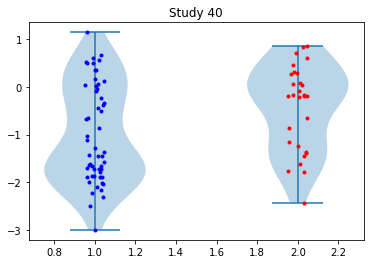

In [46]:
mw=test_res(40,'../dysbiosis_index/40_dysbiosis_index.txt')

exp ../studies/16/ - AmpliconExperiment with 119 samples, 2116 features


/home/amnon/miniconda3/envs/calour/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Healthy median -1.704015(mean -2.153148). sick median -2.265894 (mean -2.550233)
MannwhitneyuResult(statistic=1939.5, pvalue=0.9786155132856728)


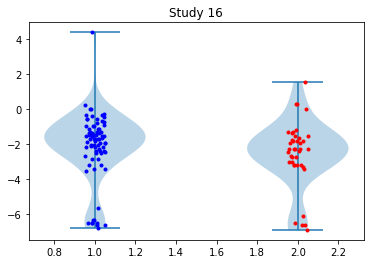

In [47]:
mw=test_res(16,'../dysbiosis_index/binary/16.txt',)

exp ../studies/40/ - AmpliconExperiment with 85 samples, 3917 features
Healthy median -2.157563(mean -2.149054). sick median -2.032722 (mean -2.006812)
MannwhitneyuResult(statistic=624.0, pvalue=0.04110544746886762)


/home/amnon/miniconda3/envs/calour/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


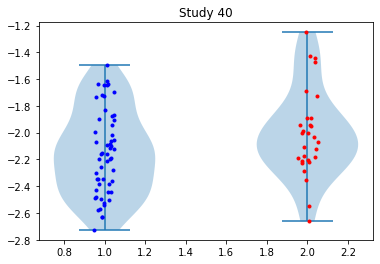

In [48]:
mw=test_res(40,'../dysbiosis_index/samplerank/40.txt',)

In [49]:
studies=pd.read_csv('../studies/index.csv',sep='\t')

In [50]:
db_binary={}
db_gevers={}
db_freqs={}
db_ranks={}
db_samplerank={}
for cs in studies.iterrows():
    cs = cs[1]
    print('%s (%s)' % (cs['disease'], cs['sampleid']))
    print('tzipi')
    csid = cs['sampleid']
    mw=test_res(csid,'../dysbiosis_index/%s_dysbiosis_index.txt' % csid,plotit=False)
    db_gevers[csid]=mw
    print('binary')
    mw=test_res(csid,'../dysbiosis_index/binary/%s.txt' % csid,plotit=False)
    db_binary[csid]=mw
    print('freq')
    mw=test_res(csid,'../dysbiosis_index/freqs/%s.txt' % csid,plotit=False)
    db_freqs[csid]=mw
    print('rank')
    mw=test_res(csid,'../dysbiosis_index/ranks/%s.txt' % csid,plotit=False)
    db_ranks[csid]=mw
    mw=test_res(csid,'../dysbiosis_index/samplerank/%s.txt' % csid,plotit=False)
    db_samplerank[csid]=mw


Alzheimer (17)
tzipi
exp ../studies/17/ - AmpliconExperiment with 50 samples, 2307 features
Healthy median -1.858416(mean -1.864470). sick median -1.697781 (mean -1.772650)
MannwhitneyuResult(statistic=255.0, pvalue=0.1343713862105385)
binary
exp ../studies/17/ - AmpliconExperiment with 50 samples, 2307 features
Healthy median -2.411694(mean -2.404409). sick median -0.995513 (mean -1.244474)
MannwhitneyuResult(statistic=140.0, pvalue=0.0004225101832644758)
freq
exp ../studies/17/ - AmpliconExperiment with 50 samples, 2307 features
Healthy median -6.302661(mean -5.858335). sick median -4.574364 (mean -4.138208)
MannwhitneyuResult(statistic=195.0, pvalue=0.011599743657534665)
rank
exp ../studies/17/ - AmpliconExperiment with 50 samples, 2307 features


KeyError: "None of [Index(['s021', 's002', 's049', 's040', 's044', 's014', 's006', 's024', 's026',\n       's010', 's020', 's009', 's019', 's007', 's013', 's032', 's023', 's004',\n       's001', 's015', 's025', 's037', 's012', 's022', 's027'],\n      dtype='object', name='SampleID')] are in the [index]"

In [ ]:
studies['disease'].values

In [ ]:
    disease_colors = {xx:(0,0,0) for xx in studies.disease.values}
    disease_colors.update({'HIV': (1.00,0.93,0.35),'Autism': (0.50,0.99,0.52),'Bipolar': (1.00, 0.63, 0.00),
         'IBD_Crohn disease': (0.72,0.11,0.11),'IBD_Ulcerative Colitis': (0.043,1,0.97),
         'IBD_Inflammtory bowel disease': (0.90,0.59,0.043),
         'Diabetes T2': (0.47,0.53,0.80),
         'Depression': (0.48,0.12,0.64),
         'Obesity': (0.25,0.32,0.71),
         'Parkinson': (0.29,0.08,0.55),
         'Schizophrenia': (0.88,0.75,0.91),     
         'Gastroenteritis': (0.94,0.33,0.31),
         'Heart diseases': (0.33,0.43,1.00),
         'Irritable bowel syndrom': (0.90,0.45,0.45),
         'Alzheimer': (0.83, 0.83, 0.83), 'Anorexia': (0.83, 0.83, 0.83), 'Cancer': (0.83, 0.83, 0.83), 'Autoimmun diseases': (0.83, 0.83, 0.83), 'C.difficile infection': (0.83, 0.83, 0.83), 
         'Cancer': (0.83, 0.83, 0.83), 'Chronic fatigue syndrome': (0.83, 0.83, 0.83), 'Diabetes T1': (0.83, 0.83, 0.83),  'Gout': (0.83, 0.83, 0.83),
         'Hepatitis B': (0.83, 0.83, 0.83), 'Hepatitis C': (0.83, 0.83, 0.83), 'Hypertension': (0.83, 0.83, 0.83), 
         'Lupus': (0.83, 0.83, 0.83), 'Pancreatitis': (0.83, 0.83, 0.83), 'Psoriasis': (0.83, 0.83, 0.83), 'Rheumatoid arthritis': (0.83, 0.83, 0.83), 
                
         })


In [ ]:
def compare_pvals2(db1,db2,name1,name2, minval=1E-5, show_text=True):
    f=plt.figure()
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([minval*0.9,1])
    plt.xlim([minval*0.9,1])
    plt.plot([minval*0.9,1],[minval*0.9,1],'k')
    plt.plot([minval*0.9,1],[0.05,0.05],':k')
    plt.plot([0.05,0.05],[minval,1],':k')
    for idx,cid in enumerate(db_binary.keys()):
        cx = np.max([db1[cid],minval])
        cy = np.max([db2[cid],minval])
        cdisease=studies[studies.sampleid==cid]['disease'].values[0]
        cstudy=studies[studies.sampleid==cid]['study'].values[0]
        plt.plot(cx, cy,'.',markersize=30, color=disease_colors[cdisease],label=cdisease)
        if show_text:
            plt.text(cx, cy*0.8,cdisease+'_'+cstudy)
    f.set_size_inches(10,10)
    plt.xlabel(name1)
    plt.ylabel(name2)
#     plt.legend()
    return f

In [ ]:
def compare_pvals(db1,db2,name1,name2, minval=1E-5, show_text=True, show_num=False):
    f=plt.figure()
#     plt.yscale('log')
#     plt.xscale('log')
    plt.xlim([-np.log10(1),-np.log10(minval*0.9)])
    plt.ylim([-np.log10(1),-np.log10(minval*0.9)])
    ticks=np.arange(-np.log10(1),-np.log10(minval*0.9))
    plt.xticks(ticks, 10**(-ticks))
    plt.yticks(ticks, 10**(-ticks))
    plt.plot([-np.log10(minval*0.9),-np.log10(1)],[-np.log10(minval*0.9),-np.log10(1)],'k')
    plt.plot([-np.log10(minval*0.9),-np.log10(1)],[-np.log10(0.05),-np.log10(0.05)],':k')
    plt.plot([-np.log10(0.05),-np.log10(0.05)],[-np.log10(minval),-np.log10(1)],':k')
    # draw the rectangles
    rect = mpl.patches.Rectangle((0,0),-np.log10(0.05),-np.log10(0.05),linewidth=1,edgecolor='w',facecolor=(1,0.85,0.85))
    plt.gca().add_patch(rect)
    rect = mpl.patches.Rectangle((0,-np.log10(0.05)),-np.log10(0.05),-np.log10(minval),linewidth=1,edgecolor='w',facecolor=(0.85,1,0.85))
    plt.gca().add_patch(rect)
    rect = mpl.patches.Rectangle((-np.log10(0.05),0),-np.log10(minval),-np.log10(0.05),linewidth=1,edgecolor='w',facecolor=(0.9,0.9,1))
    plt.gca().add_patch(rect)

    
    for idx,cid in enumerate(db_binary.keys()):
        cx = np.max([db1[cid],minval])
        cy = np.max([db2[cid],minval])
        cdisease=studies[studies.sampleid==cid]['disease'].values[0]
        cstudy=studies[studies.sampleid==cid]['study'].values[0]
        plt.plot(-np.log10(cx), -np.log10(cy),'.',markersize=30, color=disease_colors[cdisease],label=cdisease)
        if cx<=minval and cy<=minval:
            print('*** study %s cx %f cy %f' % (cdisease+'_'+cstudy, cx, cy))
            pass
        if show_text:
            plt.text(-np.log10(cx), -np.log10(cy*0.8),cdisease+'_'+cstudy)
        if show_num:
            cidnum = studies[studies['sampleid']==cid]['dys_number'].values[0]
            plt.text(-np.log10(cx), -np.log10(cy)-0.01,str(cidnum), horizontalalignment='center',verticalalignment='center',fontdict={'weight': 'bold', 'color':'black'})
            plt.text(-np.log10(cx), -np.log10(cy)+0.01,str(cidnum), horizontalalignment='center',verticalalignment='center',fontdict={'weight': 'bold', 'color':'black'})
            plt.text(-np.log10(cx)-0.01, -np.log10(cy),str(cidnum), horizontalalignment='center',verticalalignment='center',fontdict={'weight': 'bold', 'color':'black'})
            plt.text(-np.log10(cx)+0.01, -np.log10(cy),str(cidnum), horizontalalignment='center',verticalalignment='center',fontdict={'weight': 'bold', 'color':'black'})
            plt.text(-np.log10(cx), -np.log10(cy),str(cidnum), horizontalalignment='center',verticalalignment='center',fontdict={'weight': 'bold', 'color':'white'})
            print('ID %d - %s %s' % (cidnum, cdisease, cstudy))
    f.set_size_inches(10,10)
    plt.xlabel(name1)
    plt.ylabel(name2)
#     plt.legend()
    return f

In [ ]:
f=compare_pvals(db_binary,db_gevers,'binary','gevers')

In [ ]:
f=compare_pvals(db_freqs,db_gevers,'freqs','gevers')

In [ ]:
f=compare_pvals(db_samplerank,db_gevers,'samplerank','gevers')

In [ ]:
f=compare_pvals(db_samplerank,db_gevers,'samplerank','gevers',show_text=False, show_num=True)
f.savefig('../figures/dysbiosis-with-numbers.pdf')

In [ ]:
f=compare_pvals(db_samplerank,db_gevers,'pval (SampleRank)','pval (Gevers)',show_text=False)
f.savefig('../figures/dysbiosis-rank-gevers.pdf')

In [ ]:
f=plt.figure()
bins=np.logspace(-5,0,10)
plt.hist(db_samplerank.values(),bins,alpha=0.5)
plt.hist(db_gevers.values(),bins,alpha=0.5)
plt.xscale('log')
plt.xlabel('p-value')
plt.ylabel('number of cohorts')
plt.legend(('Nonspecific','Gevers'))
f.savefig('../figures/dysbiosis-index-pvals.pdf')

In [ ]:
print(sp.stats.mannwhitneyu(list(db_samplerank.values()),list(db_gevers.values())))
print(np.mean(list(db_samplerank.values())))
print(np.mean(list(db_gevers.values())))
print(np.median(list(db_samplerank.values())))
print(np.median(list(db_gevers.values())))

In [ ]:
mw=test_res(2,'../dysbiosis/2_dysbiosis_index.txt',)

In [ ]:
mw=test_res(2,'../dysbiosis/freqs/2.txt',)

In [ ]:
mw=test_res(2,'../dysbiosis/samplerank/2.txt',)

In [ ]:
mw=test_res(24,'../dysbiosis/ranks/24.txt',)

In [ ]:
mw=test_res(24,'../dysbiosis/binary/24.txt',)

In [ ]:
studies[studies.sampleid==62]

In [ ]:
aa = ca.read_amplicon('../studies/24/all.biom','../studies/24/up.map.csv',min_reads=1000,normalize=10000, sparse=False)

In [ ]:
aaa=aa.filter_ids(ns._feature_id.values)

In [ ]:
aa1=aaa.filter_samples('type','HC')
aa2=aaa.filter_samples('type','disease')

In [ ]:
mean1=np.mean(aa1.data,axis=0)
mean2=np.mean(aa2.data,axis=0)
std1=np.std(aa1.data,axis=0)
std2=np.std(aa2.data,axis=0)
mdiff = mean2 - mean1
mz = 2 * mdiff / (std1+std2)
aaa.feature_metadata['zscore'] = mz
aaa.feature_metadata['mean'] = mdiff
aaa.feature_metadata['std'] = (std1+std2)/2

In [ ]:
cu.splot(aaa,'type')

In [ ]:
aaa.feature_metadata=aaa.feature_metadata.join(ns.set_index('_feature_id'),lsuffix='l',on='_feature_id',how='inner')

In [ ]:
cu.splot(aaa,'type')

In [ ]:
ns

In [ ]:
dd=aa.diff_abundance('type','HC')

In [ ]:
dd

In [ ]:
cu.splot(dd,'type')

In [ ]:
ss='TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGACGCTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGGTGTCTTGAGTACAGTAGAGGCAGGCGGAATTCGTGG'
len(ss)

In [ ]:
aa.diff_abundance()